In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew

In [2]:
#Leo los csv y los paso a un dataframe
train = pd.read_csv('house_train_raw.csv')
test = pd.read_csv('houses_test_raw.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Veo dimensiones del dataframe
print ("Train: ",train.shape[0],"filas, y ",train.shape[1],"columnas")
print ("Test: ",test.shape[0],"filas, and ",test.shape[1],"columnas")

Train:  1460 filas, y  81 columnas
Test:  1459 filas, and  80 columnas


In [5]:
#Borro nulos de 'SalePrice' para que este completa
train.dropna(axis=0, subset=['SalePrice'], inplace=True)
#Borro 'SalePrice' de train_data usar en el medelo de entrenamiento 
train_data = train.drop(['SalePrice'], axis=1)

c:\Users\notebook\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


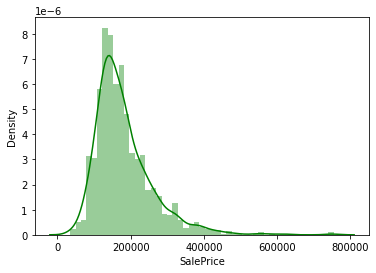

In [6]:
#Veo distribucion de 'SalePrice' 
fig = sns.distplot(train['SalePrice'],color='green')

In [7]:
#Le aplico log a 'SalePrice' para que su distribucion sea normal
train['SalePrice']=np.log1p(train['SalePrice'])

c:\Users\notebook\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


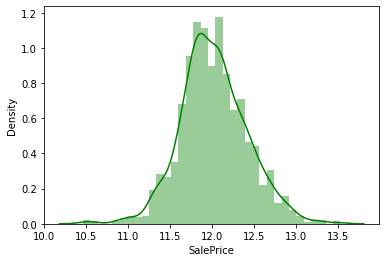

In [8]:
#Veo distribucion de 'SalePrice' con el log ya aplicado
fig = sns.distplot(train['SalePrice'],color='green')

In [9]:
#Veo columnas que tienen mas correlacion con 'SalePrice'
cor= train[:].corr()
cor=cor.sort_values(['SalePrice'],ascending=False)
cor.SalePrice

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

<AxesSubplot:>

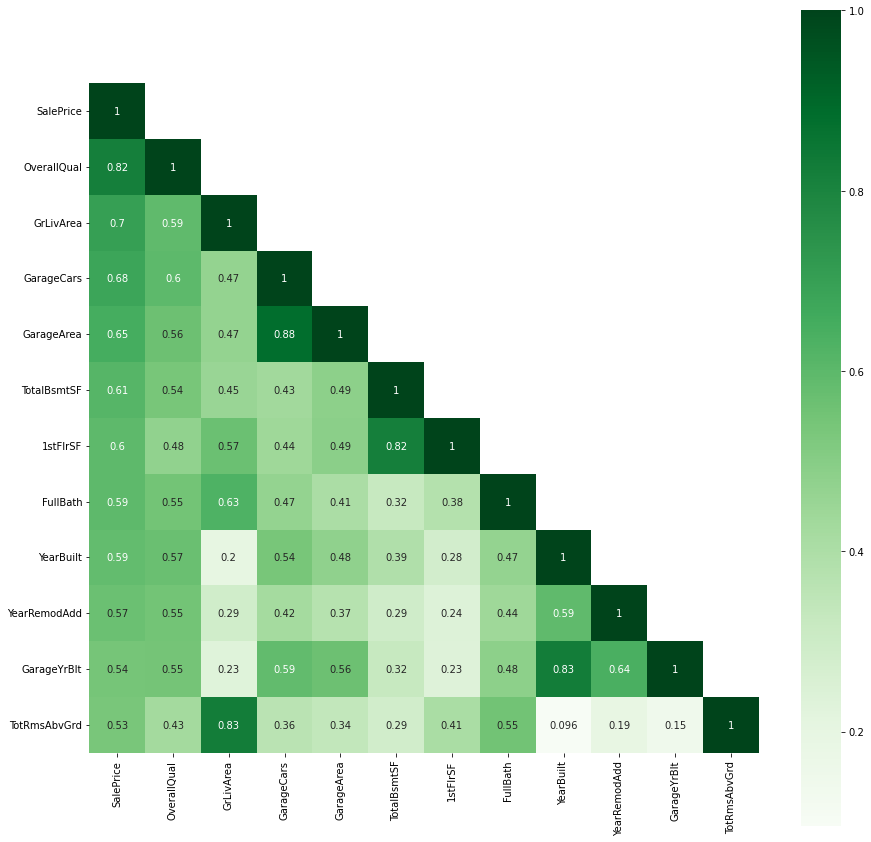

In [10]:
#Hago heatmap de las columnas con mas correlacion 
cor_mat= train[['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','YearRemodAdd','GarageYrBlt','TotRmsAbvGrd']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(15,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True,cmap="Greens")

In [11]:
#Busco nulos en las columnas de los dataframe
def deteccion_nulos(df,plot=True,rotation=45,figsize=(10,5),*kwargs):
    labels,values,percent = list(),list(),list()
    if df.isna().sum().sum()>0:
        for column in df.columns:
            if df[column].isna().sum():
                labels.append(column)
                values.append(df[column].isna().sum())
                percent.append((df[column].isna().sum() / df.shape[0])*100)
        #Make a dataframe
        missings=pd.DataFrame({'Columna':labels,'Val_nulos':values,'PorcentVacio':percent}).sort_values(by='PorcentVacio',ascending=False)
        
        if plot:
            plt.figure(figsize=figsize)
            plot = sns.barplot(x=missings.Columna,y=round(missings.PorcentVacio, 2), palette = "rocket")
            for i in plot.patches:
                plot.annotate(i.get_height(),
                (i.get_x() + i.get_width() / 2, i.get_height()),
                ha = 'center', va = 'baseline', fontsize = 12,
                color = 'black', xytext = (0,1),
                textcoords = 'offset pixels')
            locs, labels = plt.xticks()
            plt.setp(labels, rotation=rotation,size=16)
            plt.xlabel('Columna',size=18)
            plt.ylabel('Porcent',size=18)
            plot.set_title('Porcent valores nulos',size=18)
            return missings
    else:
            return False

,Columna,Val_nulos,PorcentVacio
16,PoolQC,1453,99.520548
18,MiscFeature,1406,96.301370
1,Alley,1369,93.767123
17,Fence,1179,80.753425
10,FireplaceQu,690,47.260274
0,LotFrontage,259,17.739726
11,GarageType,81,5.547945
12,GarageYrBlt,81,5.547945
13,GarageFinish,81,5.547945
14,GarageQual,81,5.547945


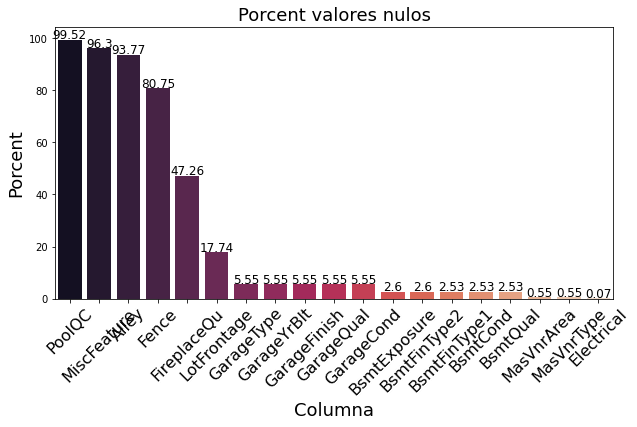

In [12]:
deteccion_nulos(train_data)

,Columna,Val_nulos,PorcentVacio
29,PoolQC,1456,99.794380
31,MiscFeature,1408,96.504455
2,Alley,1352,92.666210
30,Fence,1169,80.123372
21,FireplaceQu,730,50.034270
1,LotFrontage,227,15.558602
28,GarageCond,78,5.346127
23,GarageYrBlt,78,5.346127
27,GarageQual,78,5.346127
24,GarageFinish,78,5.346127


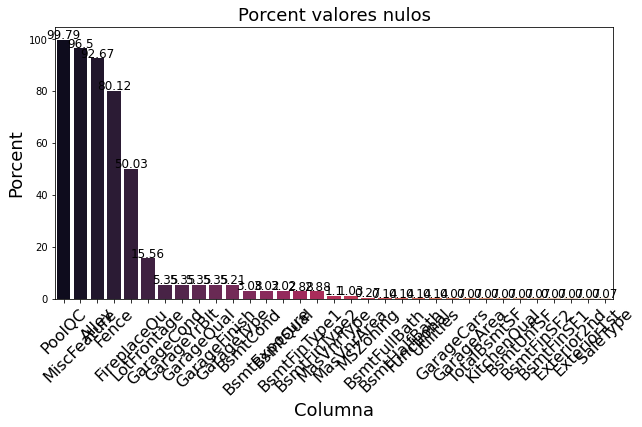

In [13]:
deteccion_nulos(test)

In [14]:
#Borro columnas con gran cantidad de nulos
train_data.drop(['PoolQC','MiscFeature','Alley','Fence','Id','FireplaceQu'],axis=1,inplace=True)
train.drop(['PoolQC','MiscFeature','Alley','Fence','Id','FireplaceQu'],axis=1,inplace=True)
test.drop(['PoolQC','MiscFeature','Alley','Fence','Id','FireplaceQu'],axis=1,inplace=True)

In [15]:
#Selecciono categorias 
categorical_cols = {cname for cname in train.columns if train[cname].dtype == "object"}
numerical_cols = {cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']}

C:\Users\notebook\AppData\Local\Temp\ipykernel_39520\4247802275.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  n=len(train[numerical_cols].columns)


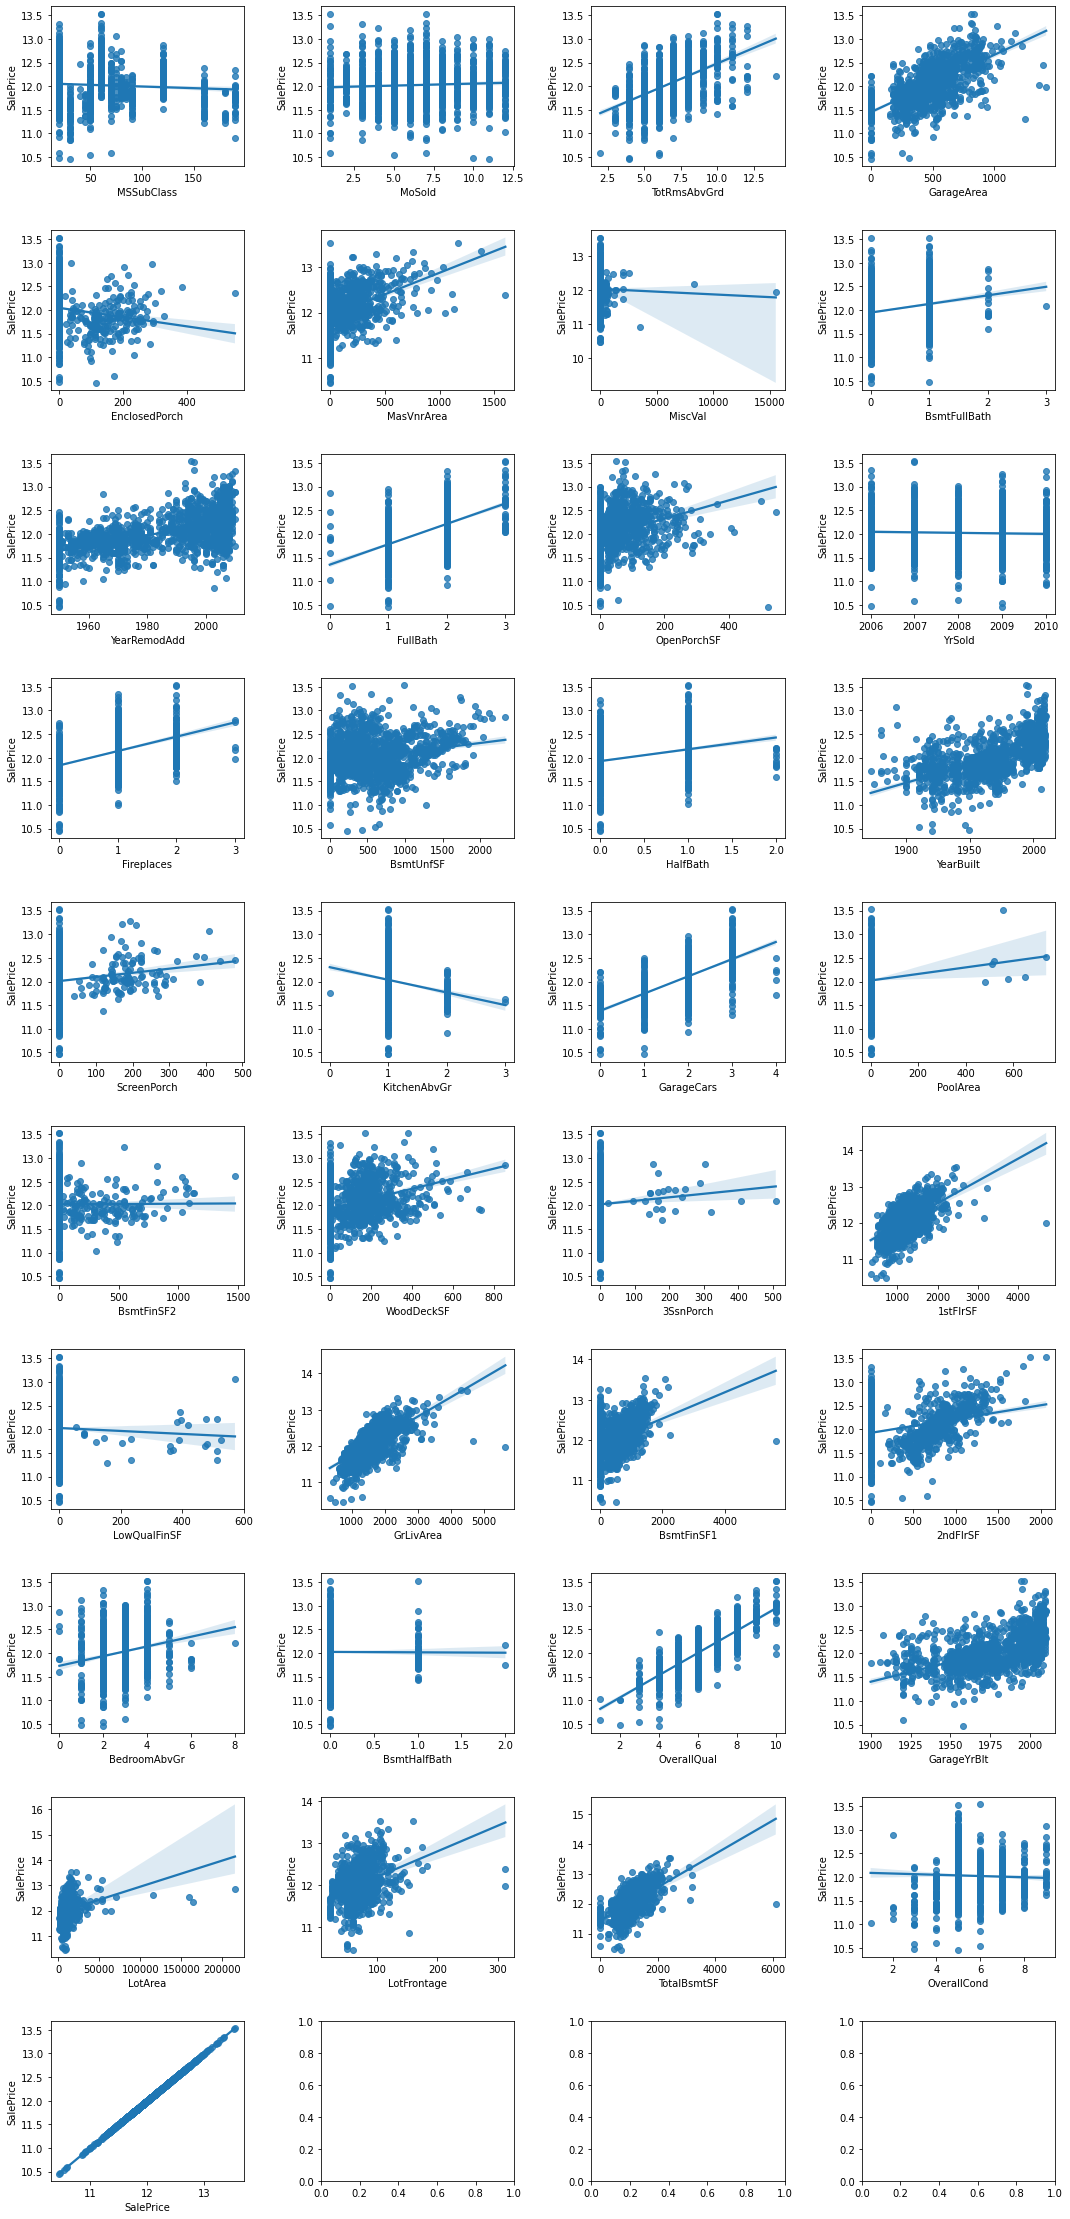

In [16]:
#Visualizo la correlacion de 'SalePrice' con las otras columnas 
n=len(train[numerical_cols].columns)
f, axes = plt.subplots(nrows=(n-1)//4 +1,ncols=4,squeeze=False,figsize=(18,4*((n-1)//4 +1))) # represent them on 4 columnms
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4) # increase space between plots

for col, ax in zip(numerical_cols, axes.flatten()[:n]):
    sns.regplot(data=train,x=col,y='SalePrice', ax=ax)

plt.show()

LUEGO DE VISUALIZAR LOS GRAFICOS TOMO LOS QUE MAS RELEVANCIA TIENEN Y LE SACO LOS OUTLIERS

In [17]:
train =train.drop(train[(train['GrLivArea']>4000)].index)
train =train.drop(train[(train['GarageArea']>1200)].index)
train =train.drop(train[(train['TotalBsmtSF']>3000)].index)
train =train.drop(train[(train['1stFlrSF']>3000)].index)

In [18]:
train_data =train_data.drop(train_data[(train_data['GrLivArea']>4000)].index)
train_data =train_data.drop(train_data[(train_data['GarageArea']>1200)].index)
train_data =train_data.drop(train_data[(train_data['TotalBsmtSF']>3000)].index)
train_data =train_data.drop(train_data[(train_data['1stFlrSF']>3000)].index)

In [19]:
test =test.drop(test[(test['GrLivArea']>4000)].index)
test =test.drop(test[(test['GarageArea']>1200)].index)
test =test.drop(test[(test['TotalBsmtSF']>3000)].index)
test =test.drop(test[(test['1stFlrSF']>3000)].index)

C:\Users\notebook\AppData\Local\Temp\ipykernel_39520\3582023524.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  n=len(train[numerical_cols].columns) # number of plots


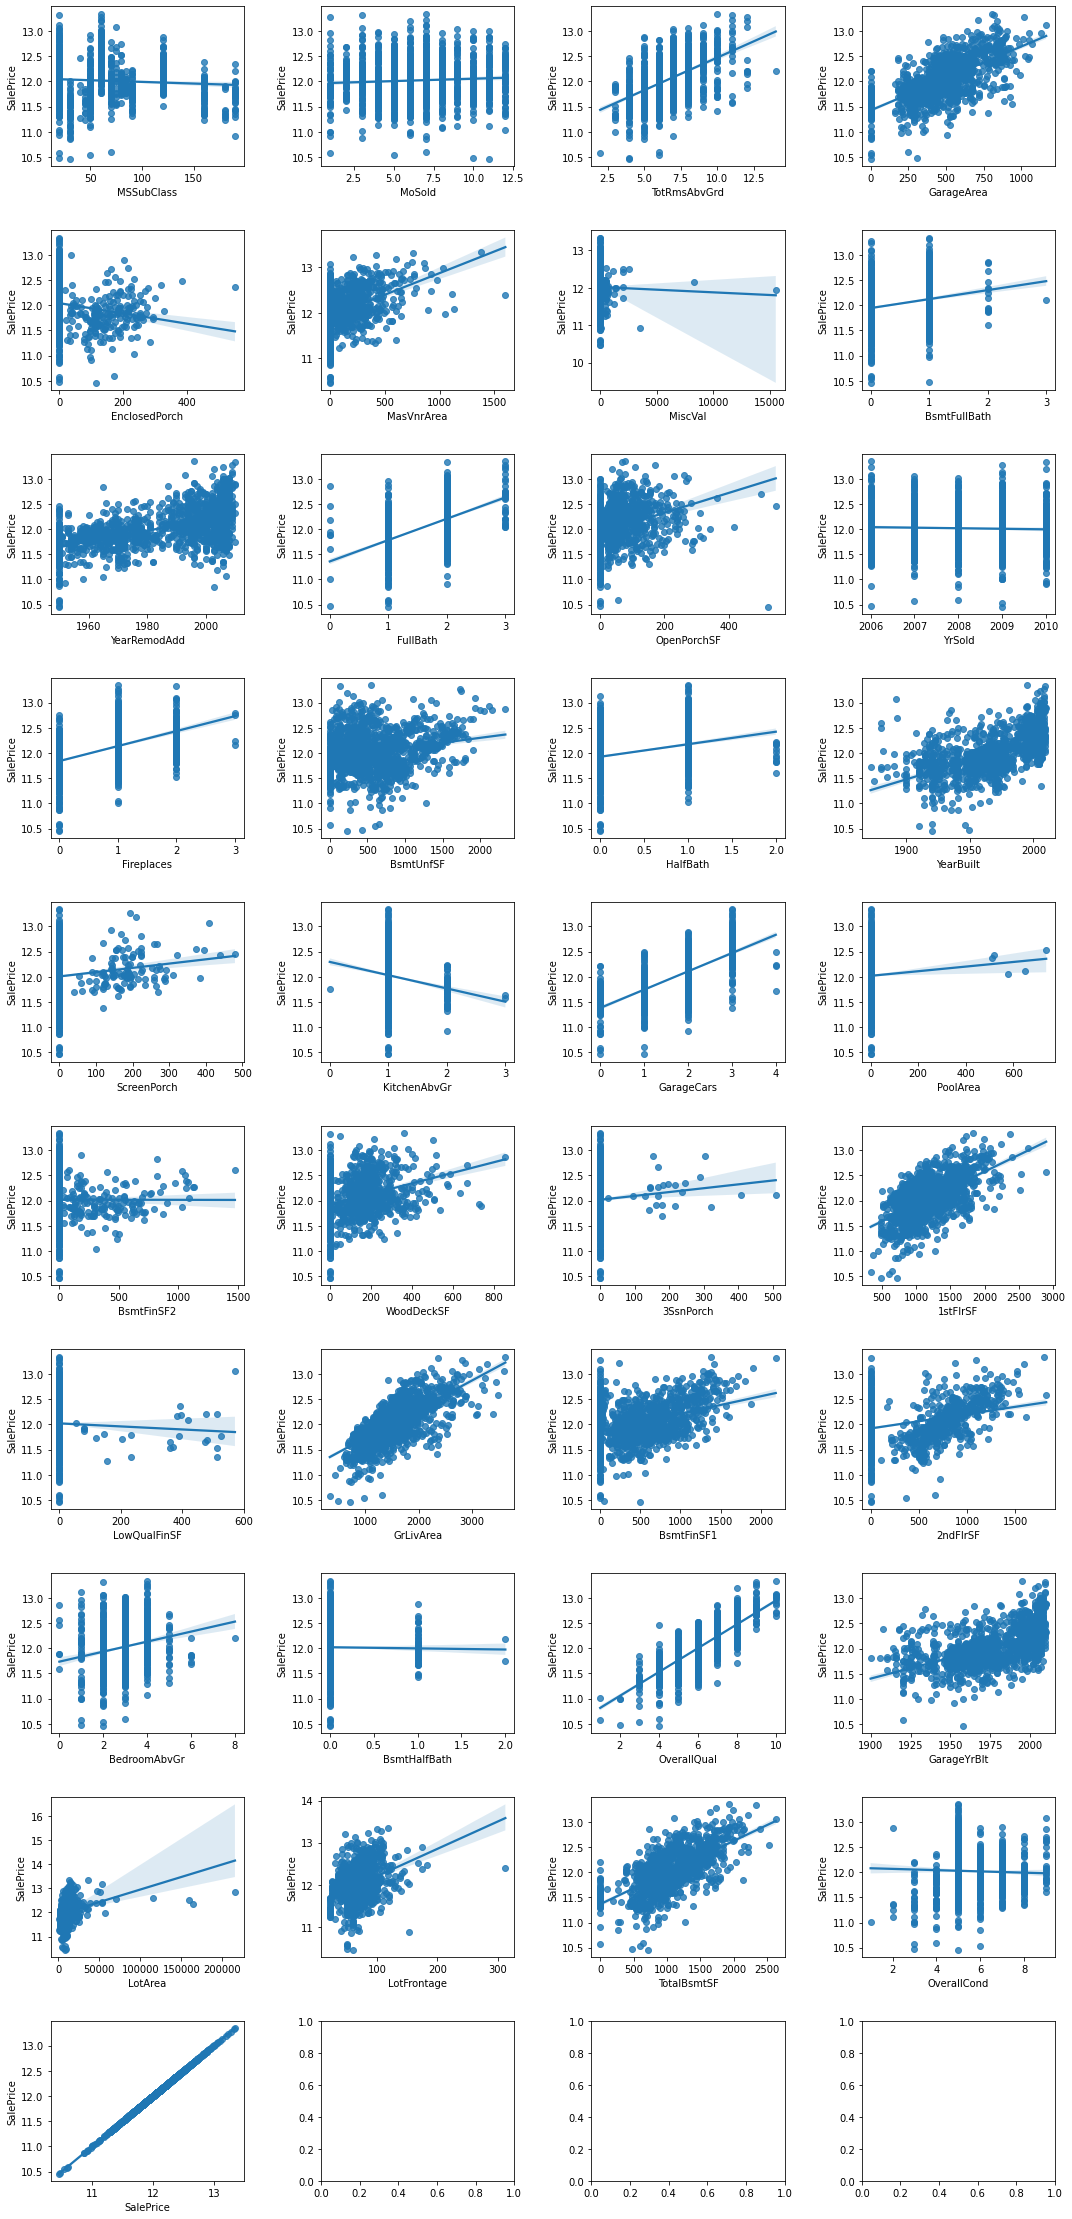

In [20]:
#Veo como quedan los graficos
n=len(train[numerical_cols].columns) # number of plots
f, axes = plt.subplots(nrows=(n-1)//4 +1,ncols=4,squeeze=False,figsize=(18,4*((n-1)//4 +1))) # represent them on 4 columnms
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4) # increase space between plots

for col, ax in zip(numerical_cols, axes.flatten()[:n]):
    sns.regplot(data=train,x=col,y='SalePrice', ax=ax)

plt.show()

VUELVO A VER LOS NULOS DE LAS COLUMNAS PARA ACOMODAR LOS QUE QUEDAN

,Columna,Val_nulos,PorcentVacio
0,LotFrontage,257,17.736370
9,GarageType,81,5.590062
10,GarageYrBlt,81,5.590062
11,GarageFinish,81,5.590062
12,GarageQual,81,5.590062
13,GarageCond,81,5.590062
5,BsmtExposure,38,2.622498
3,BsmtQual,37,2.553485
4,BsmtCond,37,2.553485
6,BsmtFinType1,37,2.553485


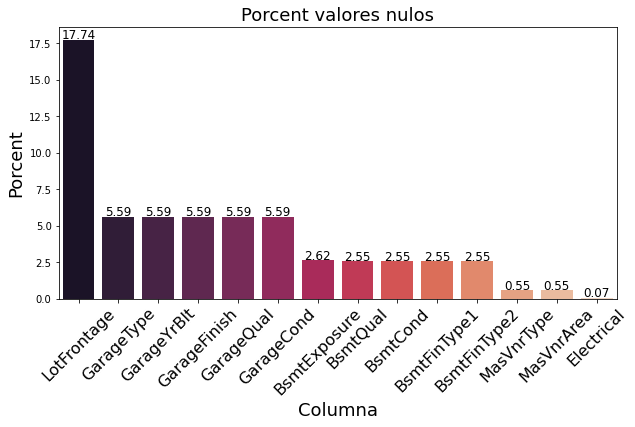

In [21]:
deteccion_nulos(train_data)

,Columna,Val_nulos,PorcentVacio
0,LotFrontage,257,17.736370
9,GarageType,81,5.590062
10,GarageYrBlt,81,5.590062
11,GarageFinish,81,5.590062
12,GarageQual,81,5.590062
13,GarageCond,81,5.590062
5,BsmtExposure,38,2.622498
3,BsmtQual,37,2.553485
4,BsmtCond,37,2.553485
6,BsmtFinType1,37,2.553485


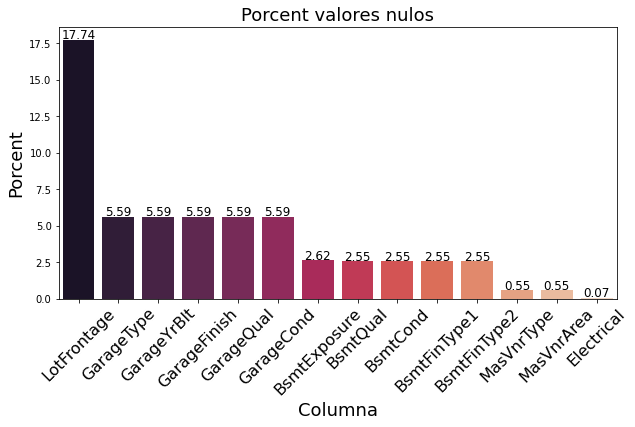

In [22]:
deteccion_nulos(train_data)

In [23]:
#Primero lleno los vacios de las columnas que considero que su información me va a ser util con la media o la moda
train_data['LotFrontage'].fillna(np.mean(train_data['LotFrontage']),inplace=True)
test['LotFrontage'].fillna(np.mean(test['LotFrontage']),inplace=True)
train_data['MSZoning'].fillna(train_data['MSZoning'].mode()[0],inplace=True)
test['MSZoning'].fillna(test['MSZoning'].mode()[0],inplace=True)
train_data['Electrical'].fillna(train_data['Electrical'].mode()[0],inplace=True)
for col in ['Functional','SaleType','KitchenQual','Exterior2nd','Exterior1st','Electrical']:
  test[col].fillna(test[col].mode()[0],inplace=True)

,Columna,Val_nulos,PorcentVacio
7,GarageType,81,5.590062
8,GarageYrBlt,81,5.590062
9,GarageFinish,81,5.590062
10,GarageQual,81,5.590062
11,GarageCond,81,5.590062
4,BsmtExposure,38,2.622498
2,BsmtQual,37,2.553485
3,BsmtCond,37,2.553485
5,BsmtFinType1,37,2.553485
6,BsmtFinType2,37,2.553485


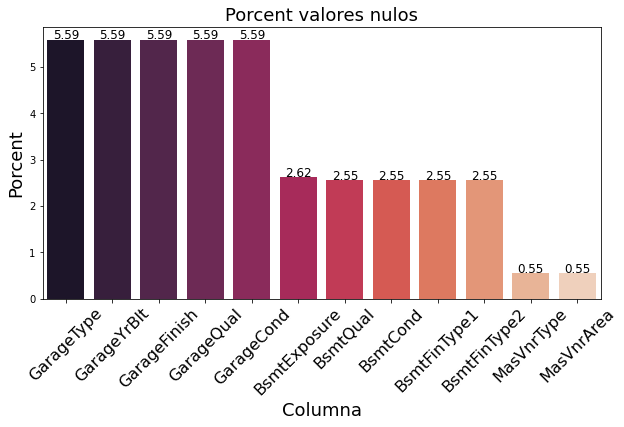

In [24]:
deteccion_nulos(train_data)

,Columna,Val_nulos,PorcentVacio
20,GarageCond,78,5.368204
19,GarageQual,78,5.368204
16,GarageFinish,78,5.368204
15,GarageYrBlt,78,5.368204
14,GarageType,76,5.230557
4,BsmtCond,44,3.028217
3,BsmtQual,43,2.959394
5,BsmtExposure,43,2.959394
6,BsmtFinType1,41,2.821748
8,BsmtFinType2,41,2.821748


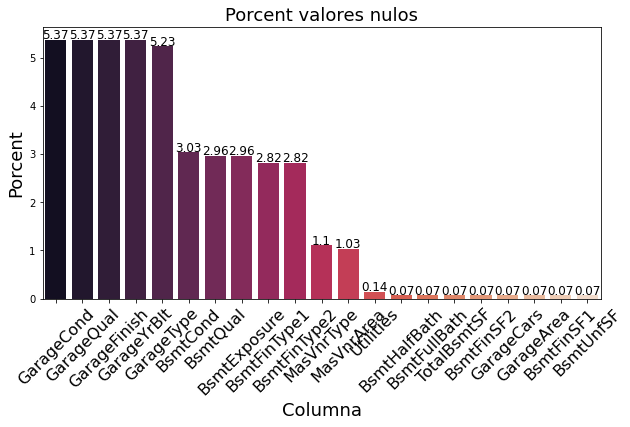

In [25]:
deteccion_nulos(test)

In [26]:
#Luego lleno los vacios restantes con 'Sin Dato' o 0
for col in ('GarageQual','GarageFinish','GarageCond','GarageType', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType'):
  train_data[col].fillna('Sin Dato',inplace=True)
for col in ('GarageYrBlt','GarageArea','GarageCars', 'MasVnrArea'):
  train_data[col].fillna(0,inplace=True)

for col in ('GarageQual','GarageFinish','GarageCond','GarageType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'MasVnrType'):
  test[col].fillna('Sin Dato',inplace=True)
for col in ('GarageYrBlt','GarageArea','GarageCars', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath','TotalBsmtSF', 'BsmtFinSF2','BsmtFinSF1','BsmtUnfSF'):
  test[col].fillna(0,inplace=True)

In [27]:
#Decido borra la columna 'Utilities' ya que visualizo que en train y test tienen valores distintos
train_data.drop(['Utilities'],axis=1,inplace=True)
test.drop(['Utilities'],axis=1,inplace=True)

In [28]:
#Guardo la columna 'SalePrice' para en la prediccion
y = train.SalePrice

In [29]:
#Separo valiables numericas de las categoricas
numerica = train_data.select_dtypes(include=['int64', 'float64'])
categorica = train_data.select_dtypes(include='object')

In [30]:
#Codifico columnas categoricas
for col in categorica.columns:
    if(test[col].dtype == 'object'):
      le=LabelEncoder()
      test[col]=le.fit_transform(test[col])
for col in categorica.columns:
    if(train_data[col].dtype == 'object'):
      le=LabelEncoder()
      train_data[col]=le.fit_transform(train_data[col])

In [31]:
#Vuelvo a ver columnas que tienen mas correlacion con 'SalePrice'
cor= train[:].corr()
cor=cor.sort_values(['SalePrice'],ascending=False)
cor.SalePrice

SalePrice        1.000000
OverallQual      0.817238
GrLivArea        0.716221
GarageCars       0.684693
GarageArea       0.668387
TotalBsmtSF      0.637734
1stFlrSF         0.607584
FullBath         0.588715
YearBuilt        0.586925
YearRemodAdd     0.567121
GarageYrBlt      0.544081
TotRmsAbvGrd     0.530163
Fireplaces       0.484011
MasVnrArea       0.428093
BsmtFinSF1       0.374017
LotFrontage      0.362303
WoodDeckSF       0.333421
OpenPorchSF      0.328337
HalfBath         0.317378
2ndFlrSF         0.314377
LotArea          0.260450
BsmtFullBath     0.234262
BsmtUnfSF        0.217774
BedroomAbvGr     0.206201
ScreenPorch      0.120416
MoSold           0.064790
3SsnPorch        0.057234
PoolArea         0.041375
BsmtFinSF2      -0.001726
BsmtHalfBath    -0.013744
MiscVal         -0.018020
OverallCond     -0.035401
YrSold          -0.037034
LowQualFinSF    -0.037352
MSSubClass      -0.070927
KitchenAbvGr    -0.148029
EnclosedPorch   -0.156934
Name: SalePrice, dtype: float64

APLICO MODELO

In [32]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

In [33]:
#Agarro las columnas con mayor correlacion con SalesPrice
x = train_data[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','OpenPorchSF','WoodDeckSF','2ndFlrSF','HalfBath','LotArea','BsmtFullBath','BsmtUnfSF','BedroomAbvGr','ScreenPorch']]
x.shape

(1449, 24)

In [38]:
#Defino los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 10)
#Instancio el modelo
model= RandomForestRegressor(n_estimators=130, random_state=25)
#Entreno modelo
model.fit(x_train, y_train)
#Guardo resultado de prediccion y calculo error
pred=model.predict(x_test)
print(np.sqrt(mean_squared_log_error( y_test, pred)))

0.010482647171520677


In [35]:
#Score del modelo
model.score(x_test,y_test)

0.8748099275635731

In [39]:
#Aplico el modelo al dataset de test
x = train_data[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','OpenPorchSF','WoodDeckSF','2ndFlrSF','HalfBath','LotArea','BsmtFullBath','BsmtUnfSF','BedroomAbvGr','ScreenPorch']]
xtest = test[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','TotRmsAbvGrd','YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','OpenPorchSF','WoodDeckSF','2ndFlrSF','HalfBath','LotArea','BsmtFullBath','BsmtUnfSF','BedroomAbvGr','ScreenPorch']]
#defino los conjuntos de train y test
x_train, x_test, y_train  = x, xtest, y
#Prediccion
pred=model.predict(x_test)
#Le saco el logaritmo que aplique al precio aplicando su opuesto a la prediccion.
pred = np.expm1(pred)
prediccion_precios = pd.DataFrame(pred)

#GUARDO MI PREDICCION EN UN CSV
prediccion_precios.to_csv('pred_test.csv')